In [311]:
import numpy as np
import pandas as pd

import xgboost as xgb


from sklearn.model_selection import (
    KFold,
    train_test_split,
    cross_val_score,
    RepeatedKFold,
    GridSearchCV,
)
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.multioutput import MultiOutputRegressor
import shap
from warnings import simplefilter

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
%matplotlib inline

In [226]:
df = pd.read_csv("./data/current_allday_data.csv.gz")

datecols = ["Datetime", "Date"]
intcols = ["Price", "Sales_Count"]

df[datecols] = df[datecols].apply(pd.to_datetime)
df[intcols] = df[intcols].apply(pd.to_numeric, downcast='integer')

In [227]:
df

,Datetime,Date,tx_id,Price,Buyer,Seller,Player,Team,Position,Season,...,Weight,image,Classification,Total_Circulation,Moment_Description,NFT_ID,Series,Set_Name,NFLALLDAY_ASSETS_URL,Sales_Count
0,2022-05-05 18:49:07,2022-05-05,5d4baa454da25b04d5af5cad22f971ed91ac69ea76f444...,10,0x4c0395008889aa20,0x62754bf5d9f9bdd5,Randall Cunningham,Philadelphia Eagles,QB,1987,...,195.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,9000,Randall Cunningham rolled to his left off of p...,2555093,Historical,Gridiron,https://assets.nflallday.com/editions/gridiron...,1
1,2022-06-15 21:39:01,2022-06-15,6c96ca996a0991d3d3d867c56ef80e53491d1ee7f11fed...,4,0x1762f9a119427234,0x66443cafc920078c,A'Shawn Robinson,Los Angeles Rams,DL,2021,...,330.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,10000,A'Shawn Robinson pushed his way through the li...,1498641,Series 1,Base,https://assets.nflallday.com/editions/base/4b0...,1
2,2022-06-15 19:34:54,2022-06-15,9b40c0168a145f926bea136dbbdaea18911a8715829e75...,220,0xb8eab8b330b6d8f3,0x4d2728f9b1f48c48,A.J. Brown,Tennessee Titans,WR,2021,...,226.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,899,Knowing he had a free play after San Francisco...,1311057,Series 1,Launch Codes,https://assets.nflallday.com/editions/launch_c...,1
3,2022-06-15 19:14:24,2022-06-15,44ed87333faebe4d1c3f038f855c7ed8fafaa8d03b1702...,32,0x3a8896d9962c3edf,0x7dece7a1d46ee9c5,A.J. Brown,Tennessee Titans,WR,2021,...,226.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,8500,Blanketed by two defenders near the pylon alon...,2233227,Series 1,Divisional Round,https://assets.nflallday.com/editions/division...,1
4,2022-06-15 20:27:38,2022-06-15,75fe78789e82547c329cb9f7c1ccfcea8495e72b08d3dd...,6,0x2bbe4f847f5d1758,0x4d2728f9b1f48c48,A.J. Green,Arizona Cardinals,WR,2021,...,210.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,8000,A.J. Green posted up in the middle of the Seat...,1951312,Series 1,Move the Chains,https://assets.nflallday.com/editions/move_the...,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602770,2022-09-21 09:36:07,2022-09-21,9d6ecd925535329504e43f4a0fe4f9fe3d10883faa3dd9...,35,0x5bb7e65418eb1d4c,0x9f969fa0351ca6b0,Zach Wilson,New York Jets,QB,2021,...,214.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,10000,Zach Wilson saw the field open up in front of ...,564156,Series 1,Base,https://assets.nflallday.com/editions/base/7aa...,1
602771,2022-09-21 11:31:41,2022-09-21,c0a13ddf4774853713bb5974c00e22715db4e67d079204...,33,0x971a99ee34308dff,0x97475da29ad1ab8e,Zach Wilson,New York Jets,QB,2021,...,214.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,10000,Zach Wilson saw the field open up in front of ...,561731,Series 1,Base,https://assets.nflallday.com/editions/base/7aa...,1
602772,2022-09-21 06:03:46,2022-09-21,72e40116dca4db82a6ec568d239a88905733c3351424cd...,9,0x1f0315e9e83c607d,0xf44c2d2b8f508092,Zay Jones,Las Vegas Raiders,WR,2021,...,200.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,10000,Zay Jones broke toward the near sideline on th...,1472935,Series 1,Base,https://assets.nflallday.com/editions/base/b2f...,3
602773,2022-09-21 05:26:57,2022-09-21,f60a36ab97353b9c579419a72b2bfb42db78eda6a5ff13...,8,0xf44c2d2b8f508092,0x542e12f2d29b171e,Zay Jones,Las Vegas Raiders,WR,2021,...,200.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,10000,Zay Jones broke toward the near sideline on th...,1472935,Series 1,Base,https://assets.nflallday.com/editions/base/b2f...,3


In [228]:
rarity_dict = {
    "COMMON": 0,
    "RARE": 1,
    "LEGENDARY": 2,
    "ULTIMATE": 3
}
df["Player"] = df["Player"].astype('category')
df["Play_Type"] = df["Play_Type"].astype('category')
df["Position"] = df["Position"].astype('category')
df["Team"] = df["Team"].astype('category')
df["NFT_ID"] = df["NFT_ID"].astype('category')
df["Rarity"] = df.apply(lambda x: rarity_dict[x.Moment_Tier], axis=1)


evaluate which categories are worth keeping

In [229]:
features = [
    "Player",
    "Play_Type",
    "Position",
    "Team",
    "Sales_Count",
    "Rarity",
    # "NFT_ID",
]
df_ohe_all_ = df[features]
df_ohe_all_ = pd.get_dummies(df_ohe_all_,prefix=['Player'], columns = ['Player'], drop_first=True)
df_ohe_all_ = pd.get_dummies(df_ohe_all_,prefix=['Play_Type'], columns = ['Play_Type'], drop_first=True)
df_ohe_all_ = pd.get_dummies(df_ohe_all_,prefix=['Position'], columns = ['Position'], drop_first=True)
df_ohe_all_ = pd.get_dummies(df_ohe_all_,prefix=['Team'], columns = ['Team'], drop_first=True)
df_ohe_all = df_ohe_all_.copy()

In [230]:
X, y = df_ohe_all, df.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)



In [231]:
params = {
    "tree_method": "hist",
    "use_label_encoder": False,
    "n_estimators": 250,
    "colsample_bylevel": 0.7,
}

model = xgb.XGBRegressor(
        **params,
        # eval_metric="auc",
        enable_categorical=True,
        max_cat_to_onehot=1,  # We use optimal partitioning exclusively
    )
model.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)])

[0]	validation_0-rmse:169.42585	validation_1-rmse:138.73717
[1]	validation_0-rmse:154.84588	validation_1-rmse:117.42304
[2]	validation_0-rmse:148.04470	validation_1-rmse:103.87448
[3]	validation_0-rmse:143.17856	validation_1-rmse:93.63758
[4]	validation_0-rmse:141.89684	validation_1-rmse:87.91165
[5]	validation_0-rmse:139.10029	validation_1-rmse:83.25703
[6]	validation_0-rmse:136.27692	validation_1-rmse:80.11232
[7]	validation_0-rmse:136.17842	validation_1-rmse:79.63407
[8]	validation_0-rmse:135.53894	validation_1-rmse:77.30766
[9]	validation_0-rmse:133.17126	validation_1-rmse:75.38773
[10]	validation_0-rmse:132.78034	validation_1-rmse:73.98720
[11]	validation_0-rmse:132.73644	validation_1-rmse:73.35198
[12]	validation_0-rmse:132.88555	validation_1-rmse:72.55099
[13]	validation_0-rmse:132.59001	validation_1-rmse:71.35101
[14]	validation_0-rmse:132.37835	validation_1-rmse:70.68605
[15]	validation_0-rmse:131.82711	validation_1-rmse:69.78735
[16]	validation_0-rmse:131.75285	validation_1-r

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.7, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=1,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=250, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [232]:
hot_features = pd.DataFrame(
    model.feature_importances_.reshape(1, len(model.feature_importances_)),
    columns=model.feature_names_in_,
)
sorted_importance = hot_features.T.sort_values(by=0, ascending=False).reset_index()

In [233]:
sorted_importance[sorted_importance['index'].str.startswith('Player_')].iloc[:50].reset_index()

,level_0,index,0
0,1,Player_Tom Brady,0.133794
1,3,Player_Patrick Mahomes II,0.075232
2,4,Player_Randall Cunningham,0.039554
3,5,Player_Justin Herbert,0.039318
4,6,Player_Trey Lance,0.034901
5,9,Player_Aaron Rodgers,0.031547
6,10,Player_Trevor Lawrence,0.016084
7,12,Player_Brett Favre,0.014445
8,13,Player_Tyreek Hill,0.013905
9,16,Player_Micah Parsons,0.009147


In [234]:
sorted_importance[sorted_importance['index'].str.startswith('Team_')].iloc[:50].reset_index()

,level_0,index,0
0,7,Team_Miami Dolphins,0.034249
1,11,Team_San Francisco 49ers,0.014473
2,14,Team_Seattle Seahawks,0.011754
3,21,Team_Los Angeles Raiders,0.007783
4,22,Team_Los Angeles Rams,0.007532
5,25,Team_Buffalo Bills,0.007146
6,46,Team_Baltimore Ravens,0.002426
7,57,Team_Green Bay Packers,0.001668
8,70,Team_Houston Texans,0.001067
9,77,Team_Washington Football Team,0.000962


In [235]:
sorted_importance[sorted_importance['index'].str.startswith('Position_')].iloc[:50].reset_index()

,level_0,index,0
0,0,Position_QB,0.151287
1,2,Position_WR,0.077942
2,15,Position_Team,0.011206
3,17,Position_TE,0.009130
4,68,Position_RB,0.001215
5,139,Position_DL,0.000295
6,190,Position_LB,0.000137
7,388,Position_P,0.000000
8,389,Position_OL,0.000000
9,391,Position_K,0.000000


In [236]:
sorted_importance[sorted_importance['index'].str.startswith('Play_Type_')].iloc[:50].reset_index()


,level_0,index,0
0,23,Play_Type_Pressure,0.007339
1,38,Play_Type_Reception,0.003844
2,40,Play_Type_Team Melt,0.003061
3,41,Play_Type_Interception,0.003017
4,43,Play_Type_Pass,0.002713
5,58,Play_Type_Player Melt,0.001538
6,78,Play_Type_Sack,0.000947
7,107,Play_Type_Rush,0.000477
8,153,Play_Type_Forced Fumble,0.000239
9,162,Play_Type_Kick Return,0.000205


We'll keep anything above ~0.0025
- top 35 players
- top 8 teams
- top 5 positions
- top 6 play_types

In [256]:
features = [
    "Player_importance",
    "Play_Type_importance",
    "Position_importance",
    "Team_importance",
    "Sales_Count",
    "Rarity",
    # "NFT_ID",
]
important_players = (
    sorted_importance[sorted_importance["index"].str.startswith("Player_")]
    .reset_index(drop=True)
    .iloc[:35]["index"]
    .str.split("Player_")
    .str[1]
    .values
)
df["Player_importance"] = df.Player.apply(
    lambda x: x if x in important_players else "Other"
)

important_teams = (
    sorted_importance[sorted_importance["index"].str.startswith("Team_")]
    .reset_index(drop=True)
    .iloc[:8]["index"]
    .str.split("Team_")
    .str[1]
    .values
)
df["Team_importance"] = df.Team.apply(
    lambda x: x if x in important_teams else "Other"
)

important_postitions = (
    sorted_importance[sorted_importance["index"].str.startswith("Position_")]
    .reset_index(drop=True)
    .iloc[:5]["index"]
    .str.split("Position_")
    .str[1]
    .values
)
df["Position_importance"] = df.Position.apply(
    lambda x: x if x in important_postitions else "Other"
)

important_play_types = (
    sorted_importance[sorted_importance["index"].str.startswith("Play_Type_")]
    .reset_index(drop=True)
    .iloc[:6]["index"]
    .str.split("Play_Type_")
    .str[1]
    .values
)
df["Play_Type_importance"] = df.Play_Type.apply(
    lambda x: x if x in important_play_types else "Other"
)


df_ohe_all_ = df[features]
df_ohe_all_ = pd.get_dummies(
    df_ohe_all_, prefix=["Player"], columns=["Player_importance"], drop_first=False
)
df_ohe_all_ = pd.get_dummies(
    df_ohe_all_, prefix=["Play_Type"], columns=["Play_Type_importance"], drop_first=False
)
df_ohe_all_ = pd.get_dummies(
    df_ohe_all_, prefix=["Position"], columns=["Position_importance"], drop_first=False
)
df_ohe_all_ = pd.get_dummies(
    df_ohe_all_, prefix=["Team"], columns=["Team_importance"], drop_first=False
)
df_ohe_all = df_ohe_all_.copy()


In [303]:
params = {
    "tree_method": "hist",
    "use_label_encoder": False,
    "n_estimators": 500,
    "colsample_bylevel": 0.7,
}
X, y = df_ohe_all, df.Price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
model = xgb.XGBRegressor(
        **params,
        enable_categorical=True,
        max_cat_to_onehot=1,  # We use optimal partitioning exclusively
    )
model.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)])

[10:39:13] WARNING: ../src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:166.87667	validation_1-rmse:137.39926
[1]	validation_0-rmse:153.01503	validation_1-rmse:115.53402
[2]	validation_0-rmse:143.64138	validation_1-rmse:100.97804
[3]	validation_0-rmse:138.33110	validation_1-rmse:91.47017
[4]	validation_0-rmse:137.05706	validation_1-rmse:85.65516
[5]	validation_0-rmse:134.41638	validation_1-rmse:80.40962
[6]	validation_0-rmse:131.17066	validation_1-rmse:76.03769
[7]	validation_0-rmse:130.44236	validation_1-rmse:73.84615
[8]	validation_0-rmse:129.28929	validation_1-rmse:71.83606
[9]	validation_0-rmse:128.60083	validation_1-rmse:70.56067
[10]	validation_0-rmse:128.51716	validation_1-rms

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.7, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=1,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [304]:
model.save_model("full.json")

In [305]:
pred = model.predict(X_test)

In [306]:
model.score(X_test, y_test)

0.5819139083584721

In [307]:
np.sqrt(mean_squared_error(y_test, pred))

121.99352302812554

In [312]:
mean_absolute_percentage_error(y_test, pred)

0.8162995345565566

<AxesSubplot: >

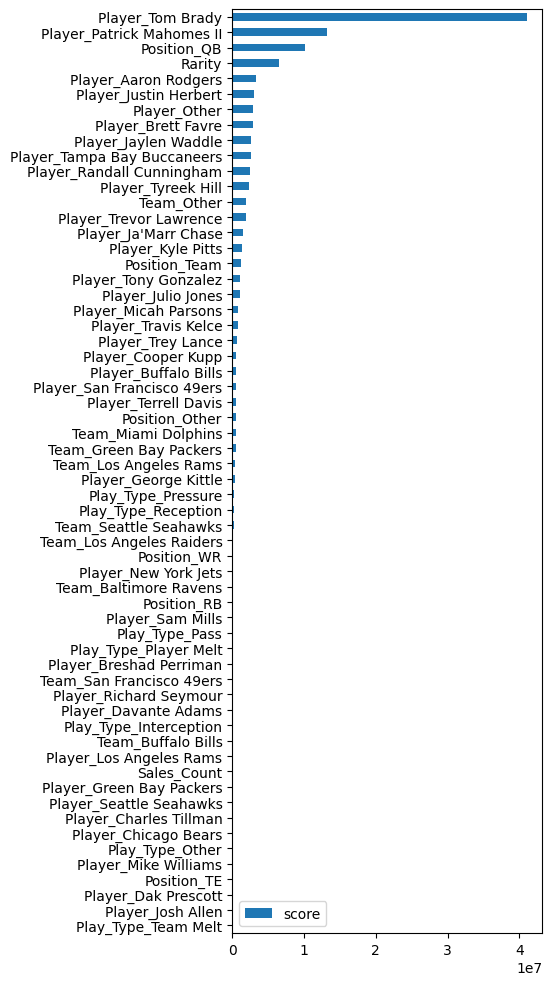

In [316]:
feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

feature_df = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
feature_df.plot(kind='barh', figsize = (4,12))

In [318]:
tree_explainer  = shap.TreeExplainer(model)
interaction_values = tree_explainer.shap_interaction_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


: 

: 

In [317]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


KeyboardInterrupt: 

In [302]:
len(feature_df)

60

In [ ]:
model.score(X_train, y_train)

In [292]:

kfold = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1234)
results = cross_val_score(
    model, X, y, cv=kfold
)

KeyboardInterrupt: 

In [272]:
results

array([-0.81949154, -0.81587697, -0.81879002, -0.81418634, -0.81346297,
       -0.81768958, -0.81215717, -0.82046052, -0.80556459, -0.81477934,
       -0.81274905, -0.81900272, -0.81832086, -0.81062761, -0.81444694,
       -0.81646689, -0.81934525, -0.80910248, -0.81555586, -0.81830806,
       -0.81742849, -0.82053573, -0.81586507, -0.81501545, -0.8132332 ,
       -0.80829501, -0.81417031, -0.81346074, -0.82466058, -0.81317185,
       -0.81418804, -0.81751658, -0.8113838 , -0.80825333, -0.82445665,
       -0.81845811, -0.80970279, -0.80737297, -0.8250277 , -0.81953973,
       -0.80821215, -0.81592395, -0.8163993 , -0.82193725, -0.80902813,
       -0.81418552, -0.81667393, -0.81873307, -0.8161031 , -0.81413244,
       -0.81056176, -0.81539637, -0.82054946, -0.8150737 , -0.82060222,
       -0.81798818, -0.8101801 , -0.81714864, -0.81656704, -0.80858796,
       -0.81833831, -0.81884624, -0.81315776, -0.81322526, -0.80793117,
       -0.81288808, -0.81646059, -0.80926144, -0.82236124, -0.82

In [270]:
gsc = GridSearchCV(
    estimator=xgb.XGBRegressor(enable_categorical=True, early_stopping_rounds=10),
    param_grid={
        "learning_rate": [0.05, 0.10, 0.15, 0.3, 0.4],
        "max_depth": [3, 4, 5, 6, 8],
        "min_child_weight": [1, 3, 5, 7],
        "gamma": [0.0, 0.1, 0.2],
        "colsample_bytree": [0.3, 0.4],
        "colsample_bylevel": [0, 0.15, 0.3, 0.7, 0.8],
        "n_estimators": [100, 250, 300]
    },
    cv=3,
    scoring="neg_mean_squared_error",
    verbose=1,
    n_jobs=-1,
)

gsc.fit(X_train, y_train)
print(gsc.best_score_)
print(gsc.best_params_)

Fitting 3 folds for each of 9000 candidates, totalling 27000 fits


KeyboardInterrupt: 

In [58]:
features = [
    "Player",
    "Play_Type",
    "Position",
    "Team",
    "Sales_Count",
    "Rarity",
    # "NFT_ID",
]

params = {
    "tree_method": "hist",
    "use_label_encoder": False,
    "n_estimators": 100,
    "colsample_bylevel": 0.7,
}

X, y = df[features], df.Price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

model = xgb.XGBRegressor(
        **params,
        enable_categorical=True,
        max_cat_to_onehot=1,  # We use optimal partitioning exclusively
    )
model.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)])

[0]	validation_0-rmse:171.52327	validation_1-rmse:134.16321
[1]	validation_0-rmse:159.56809	validation_1-rmse:109.83906
[2]	validation_0-rmse:153.32542	validation_1-rmse:93.85800
[3]	validation_0-rmse:147.48628	validation_1-rmse:81.81966
[4]	validation_0-rmse:142.80357	validation_1-rmse:73.93545
[5]	validation_0-rmse:140.46178	validation_1-rmse:68.85812
[6]	validation_0-rmse:138.95986	validation_1-rmse:65.21667
[7]	validation_0-rmse:137.21419	validation_1-rmse:63.07644
[8]	validation_0-rmse:136.39010	validation_1-rmse:61.30029
[9]	validation_0-rmse:135.67862	validation_1-rmse:60.10925
[10]	validation_0-rmse:135.31558	validation_1-rmse:59.30600
[11]	validation_0-rmse:135.03073	validation_1-rmse:58.77777
[12]	validation_0-rmse:134.78623	validation_1-rmse:58.36234
[13]	validation_0-rmse:134.64493	validation_1-rmse:57.82069
[14]	validation_0-rmse:134.63173	validation_1-rmse:57.58857
[15]	validation_0-rmse:134.62632	validation_1-rmse:57.46112
[16]	validation_0-rmse:134.49357	validation_1-rm

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.7, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=1,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

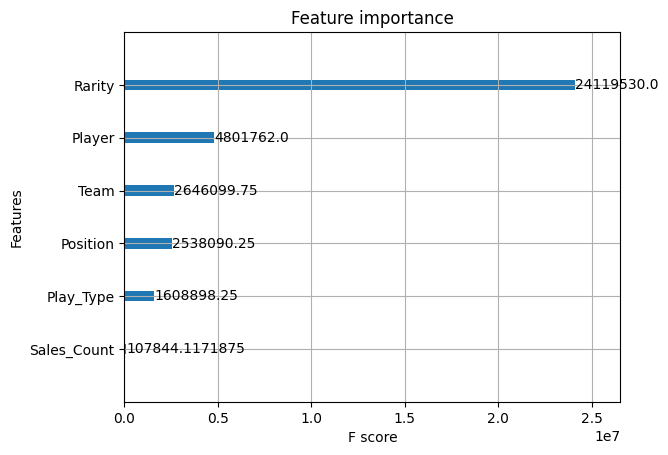

In [60]:
xgb.plot_importance(model.get_booster(), importance_type='gain')

In [57]:
model = xgb.XGBRegressor(
    **params,
    enable_categorical=True,
    max_cat_to_onehot=1,  # We use optimal partitioning exclusively
)
kfold = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1234)
results = cross_val_score(
    model, X, y, scoring="neg_mean_absolute_percentage_error", cv=kfold
)


ValueError: 'mean_absolute_percentage_error' is not a valid scoring value. Use sklearn.metrics.get_scorer_names() to get valid options.

In [48]:
results

array([-0.87299341, -1.17293811, -0.43262627, -1.95157371, -0.29840227,
       -0.28973598, -3.70046485, -3.24889063, -3.88875321, -0.80663235])

In [49]:
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: -166.63% (136.25%)


In [64]:
RepeatedKFold?

Init signature: RepeatedKFold(*, n_splits=5, n_repeats=10, random_state=None)
Docstring:     
Repeated K-Fold cross validator.

Repeats K-Fold n times with different randomization in each repetition.

Read more in the :ref:`User Guide <repeated_k_fold>`.

Parameters
----------
n_splits : int, default=5
    Number of folds. Must be at least 2.

n_repeats : int, default=10
    Number of times cross-validator needs to be repeated.

random_state : int, RandomState instance or None, default=None
    Controls the randomness of each repeated cross-validation instance.
    Pass an int for reproducible output across multiple function calls.
    See :term:`Glossary <random_state>`.

Examples
--------
>>> import numpy as np
>>> from sklearn.model_selection import RepeatedKFold
>>> X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
>>> y = np.array([0, 0, 1, 1])
>>> rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=2652124)
>>> for train_index, test_index in rkf.split(X):
...     print("TRAIN:

In [57]:
stats_df_sub = stats_df[
    (stats_df.Play_Type != "Pressure")
    # & (stats_df.Play_Type != "Block")
    & (stats_df.Rarity < 4)
]

In [58]:
stats_df_sub

,Price,Player,Play_Type,Position,Team,Moment_Tier,Sales_Count,NFT_ID,Rarity
0,10,Randall Cunningham,Pass,QB,Philadelphia Eagles,COMMON,1,2555093,1
1,4,A'Shawn Robinson,Sack,DL,Los Angeles Rams,COMMON,1,1498641,1
2,220,A.J. Brown,Reception,WR,Tennessee Titans,RARE,1,1311057,2
3,32,A.J. Brown,Reception,WR,Tennessee Titans,COMMON,1,2233227,1
4,6,A.J. Green,Reception,WR,Arizona Cardinals,COMMON,2,1951312,1
...,...,...,...,...,...,...,...,...,...
602770,35,Zach Wilson,Rush,QB,New York Jets,COMMON,1,564156,1
602771,33,Zach Wilson,Rush,QB,New York Jets,COMMON,1,561731,1
602772,9,Zay Jones,Reception,WR,Las Vegas Raiders,COMMON,3,1472935,1
602773,8,Zay Jones,Reception,WR,Las Vegas Raiders,COMMON,3,1472935,1


In [59]:
md_full = smf.mixedlm(
    "Price ~ Play_Type + Position + Rarity",
    stats_df_sub,
    groups=stats_df_sub["NFT_ID"],
)

In [60]:
mdf_full = md.fit()

/home/tirrell_le/miniconda3/envs/flow/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tirrell_le/miniconda3/envs/flow/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


KeyboardInterrupt: 

In [36]:
md = smf.mixedlm(
    "Price ~ Play_Type + Position + Rarity",
    stats_df_sub,
    groups=stats_df_sub["NFT_ID"],
)

In [37]:
mdf = md.fit()

/home/tirrell_le/miniconda3/envs/flow/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tirrell_le/miniconda3/envs/flow/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


In [39]:
s2 = mdf.summary()

/home/tirrell_le/miniconda3/envs/flow/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2705: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


In [40]:
print(s2)

                                                     Mixed Linear Model Regression Results
Model:                                           MixedLM                              Dependent Variable:                              Price    
No. Observations:                                260406                               Method:                                          REML     
No. Groups:                                      208558                               Scale:                                           4986.3149
Min. group size:                                 1                                    Log-Likelihood:                                  inf      
Max. group size:                                 7                                    Converged:                                       Yes      
Mean group size:                                 1.2                                                                                            
---------------------------------------

In [ ]:
mdf.summary()

In [30]:
s = mdf.summary()

/home/tirrell_le/miniconda3/envs/flow/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2705: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


In [31]:
print(s)

                                                         Mixed Linear Model Regression Results
Model:                                            MixedLM                                Dependent Variable:                                Price      
No. Observations:                                 260658                                 Method:                                            REML       
No. Groups:                                       208800                                 Scale:                                             273123.5534
Min. group size:                                  1                                      Log-Likelihood:                                    inf        
Max. group size:                                  7                                      Converged:                                         Yes        
Mean group size:                                  1.2                                                                                            

In [52]:
s.extra_txt

[]

In [32]:
mdf2 = md.fit(
    method=["lbfgs"]
     # method=["bfgs"]
)

/home/tirrell_le/miniconda3/envs/flow/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


LinAlgError: Singular matrix

In [ ]:
s2 = mdf2.summary()

In [33]:
len(md.group_labels)

208800

In [ ]:

# Ideal
md = smf.mixedlm(
    "Price ~ Player * Play_Type  + Position + Team + Rarity + Sales_Count",
    df,
    groups=df["NFT_ID"],
)

In [19]:
md = smf.mixedlm(
    "Price ~ Player + Play_Type + Moment_Tier ",
    df,
    groups=df["NFT_ID"],
)